In [318]:
from manager import ModelManager
from tables import Cells, Model_Waveforms, Models, Cell_Closest_Ephyz_Clusters
from pandas import DataFrame
import numpy as np
import pandas
from matplotlib import pyplot as plt

import string 
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
import hdbscan
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', 20)

In [319]:
import manager
reload(manager)
mgr = ModelManager()
mgr.server.connect()

Connecting to server...
Connecting to MySQL database...


In [320]:
protocol_cost = {
    'Steady State':       1, # 1s
    'Standard':         5*2, # 5 repetitions of 1s SS 1s stim
    'Strong':           5*2, # 5 repetitions of 1s SS 1s strong stim
    'Input Resistance': 2*2, # 2 levels of 1s SS 1s stim
}

prop_protocol = {
    'AP1Amplitude': 'Standard',
    'AP2Amplitude': 'Standard',
    'AP12AmplitudeDrop': 'Standard',
    'AP12AmplitudeChangePercent': 'Standard',
    'AP1SSAmplitudeChange': 'Standard'  ,
    
    'AP1WidthHalfHeight': 'Standard',
    'AP2WidthHalfHeight': 'Standard',
    'AP12HalfWidthChangePercent': 'Standard',
    
    'AP1WidthPeakToTrough': 'Standard',
    'AP2WidthPeakToTrough': 'Standard',
    
    'AP1RateOfChangePeakToTrough': 'Standard',
    'AP2RateOfChangePeakToTrough': 'Standard', 
    'AP12RateOfChangePeakToTroughPercentChange': 'Standard',
    
    'AP1AHPDepth': 'Standard',
    'AP2AHPDepth': 'Standard',
    'AP12AHPDepthPercentChange': 'Standard',
    
    'AP1DelayMean': 'Standard',
    'AP2DelayMean': 'Standard',
    
    'AP1DelaySD': 'Standard',
    'AP2DelaySD': 'Standard',
    
    'AP1DelayMeanStrongStim': 'Strong',
    'AP2DelayMeanStrongStim': 'Strong',
    
    'AP1DelaySDStrongStim': 'Strong',
    'AP2DelaySDStrongStim': 'Strong',
    
    'Burst1ISIMean': 'Standard',
    'Burst1ISIMeanStrongStim': 'Strong',
    
    'Burst1ISISD': 'Standard',
    'Burst1ISISDStrongStim': 'Strong',
    
    'InitialAccommodationMean': 'Standard',
    'SSAccommodationMean': 'Standard',
    'AccommodationRateToSS': 'Standard',
    'AccommodationAtSSMean': 'Standard',
    'AccommodationRateMeanAtSS': 'Standard',
    
    
    'ISIMedian': 'Standard',
    'ISICV': 'Standard',
    'ISIBurstMeanChange': 'Standard',
    
    'SpikeRateStrongStim': 'Strong',
    
    'InputResistance': 'Input Resistance',
    
    'SteadyStateAPs': 'Steady State',
}

prop_names = [
    'AP1Amplitude',
    'AP2Amplitude',
    'AP12AmplitudeDrop',
    'AP12AmplitudeChangePercent',
    'AP1SSAmplitudeChange',  
    
    'AP1WidthHalfHeight',
    'AP2WidthHalfHeight',
    'AP12HalfWidthChangePercent',
    
    'AP1WidthPeakToTrough',
    'AP2WidthPeakToTrough',
    
    'AP1RateOfChangePeakToTrough',
    'AP2RateOfChangePeakToTrough',    
    'AP12RateOfChangePeakToTroughPercentChange',
    
    'AP1AHPDepth',
    'AP2AHPDepth',
    'AP12AHPDepthPercentChange',
    
    'AP1DelayMean',
    'AP2DelayMean',
    
    'AP1DelaySD',
    'AP2DelaySD',
    
    'AP1DelayMeanStrongStim',
    'AP2DelayMeanStrongStim',
    
    'AP1DelaySDStrongStim',
    'AP2DelaySDStrongStim',
    
    'Burst1ISIMean',
    'Burst1ISIMeanStrongStim',
    
    'Burst1ISISD',
    'Burst1ISISDStrongStim',
    
    'InitialAccommodationMean',
    'SSAccommodationMean',
    'AccommodationRateToSS',
    'AccommodationAtSSMean',
    'AccommodationRateMeanAtSS',
    
    
    'ISIMedian',
    'ISICV',
    'ISIBurstMeanChange',
    
    'SpikeRateStrongStim',
    
    'InputResistance',
    
    'SteadyStateAPs',
    
    'FrequencyPassAbove',
    'FrequencyPassBelow',
    
    'RampFirstSpike',
]

In [342]:
# Get the remaining cell properties
cells = list(Cells\
    .select(Cells,Model_Waveforms.Spikes,Models.Name)\
    .join(Model_Waveforms, on=(Cells.Model_ID == Model_Waveforms.Model_id))\
    .join(Models, on=(Cells.Model_ID == Models.Model_ID))\
    .where((Model_Waveforms.Protocol == "STEADY_STATE") & (Model_Waveforms.Variable_Name == "Voltage"))\
    .order_by(Cells.Model_ID)
    .objects()
)

props = {}
for c, cell in enumerate(cells):
    for p, prop in enumerate(prop_names):
        if prop not in props:
            props[prop] = []
        
        if prop == 'SteadyStateAPs':
            props[prop].append(cell.Spikes)
            
        else:
            props[prop].append(getattr(cell, prop))
        
df = DataFrame(props, columns = prop_names)

model_ids = [c.Model_ID for c in cells]        
df.index = model_ids

In [343]:
df.head()

,AP1Amplitude,AP2Amplitude,AP12AmplitudeDrop,AP12AmplitudeChangePercent,AP1SSAmplitudeChange,AP1WidthHalfHeight,AP2WidthHalfHeight,AP12HalfWidthChangePercent,AP1WidthPeakToTrough,AP2WidthPeakToTrough,AP1RateOfChangePeakToTrough,AP2RateOfChangePeakToTrough,AP12RateOfChangePeakToTroughPercentChange,AP1AHPDepth,AP2AHPDepth,AP12AHPDepthPercentChange,AP1DelayMean,AP2DelayMean,AP1DelaySD,AP2DelaySD,AP1DelayMeanStrongStim,AP2DelayMeanStrongStim,AP1DelaySDStrongStim,AP2DelaySDStrongStim,Burst1ISIMean,Burst1ISIMeanStrongStim,Burst1ISISD,Burst1ISISDStrongStim,InitialAccommodationMean,SSAccommodationMean,AccommodationRateToSS,AccommodationAtSSMean,AccommodationRateMeanAtSS,ISIMedian,ISICV,ISIBurstMeanChange,SpikeRateStrongStim,InputResistance,SteadyStateAPs,FrequencyPassAbove,FrequencyPassBelow,RampFirstSpike
NMLCL000001,74.860976,72.47054,2.390436,-3.193167,2.200578,0.82,0.82,0.0,1.70,1.83,-49.820918,-44.612797,-10.453682,9.834584,9.170879,-6.748686,5.07,18.02,0.0,0.0,1.55,6.92,0.0,0.0,13.49,5.465,0.0,0.0,-3.571429,-3.571429,-0.111433,-11.300595,13.866022,14.6,95.817296,8.339768,2.5,10.475656,0,29.0,29.367403,2108.01
NMLCL000002,42.890156,NaN,NaN,NaN,NaN,0.17,NaN,NaN,0.76,NaN,-55.230171,NaN,NaN,-0.915226,NaN,NaN,1.59,NaN,0.0,NaN,0.62,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-100.000000,-100.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.5,4266.321045,0,29.0,143.000000,1139.19
NMLCL000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
NMLCL000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,NaN,NaN,NaN
NMLCL000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


In [344]:
df['AP1Amplitude'].fillna(0, inplace=True)
df['AP2Amplitude'].fillna(0, inplace=True)

df['AP1SSAmplitudeChange'].fillna(0, inplace=True)

df['AP1WidthHalfHeight'].fillna(0, inplace=True)
df['AP2WidthHalfHeight'].fillna(0, inplace=True)

df['AP1WidthPeakToTrough'].fillna(0, inplace=True)
df['AP2WidthPeakToTrough'].fillna(0, inplace=True)

df['AP1RateOfChangePeakToTrough'].fillna(0, inplace=True)
df['AP2RateOfChangePeakToTrough'].fillna(0, inplace=True)

df['AP1AHPDepth'].fillna(0, inplace=True)
df['AP2AHPDepth'].fillna(0, inplace=True)

df['AP1DelayMean'].fillna(2000, inplace=True)
df['AP2DelayMean'].fillna(2000, inplace=True)

df['AP1DelaySD'].fillna(0, inplace=True)
df['AP2DelaySD'].fillna(0, inplace=True)

df['AP1DelayMeanStrongStim'].fillna(2000, inplace=True)
df['AP2DelayMeanStrongStim'].fillna(2000, inplace=True)

df['AP1DelaySDStrongStim'].fillna(0, inplace=True)
df['AP2DelaySDStrongStim'].fillna(0, inplace=True)

df['Burst1ISIMean'].fillna(2000, inplace=True)
df['Burst1ISIMeanStrongStim'].fillna(2000, inplace=True)

df['Burst1ISISD'].fillna(0, inplace=True)
df['Burst1ISISDStrongStim'].fillna(0, inplace=True)

df['AccommodationRateMeanAtSS'].fillna(2000, inplace=True)

df['ISIMedian'].fillna(2000, inplace=True)

df['ISICV'].fillna(0, inplace=True)

df['ISIBurstMeanChange'].fillna(0, inplace=True)

df['SpikeRateStrongStim'].fillna(0, inplace=True)

df['InputResistance'].fillna(df['InputResistance'].mean(), inplace=True)

df['FrequencyPassAbove'].fillna(29, inplace=True)
df['FrequencyPassBelow'].fillna(143, inplace=True)

df['RampFirstSpike'].fillna(5000, inplace=True)

for index, row in df.iterrows():
    
    # No APs
    if(row['AP1Amplitude'] == 0 and row['AP2Amplitude'] == 0):
        df.at[index, 'AP12AmplitudeDrop'] = 0
        df.at[index, 'AP12AmplitudeChangePercent'] = 0
        df.at[index, 'AP1SSAmplitudeChange'] = 0
        df.at[index, 'AP12HalfWidthChangePercent'] = 0
        df.at[index, 'AP12RateOfChangePeakToTroughPercentChange'] = 0
        df.at[index, 'AP12AHPDepthPercentChange'] = 0
        df.at[index, 'InitialAccommodationMean'] = 0
        df.at[index, 'SSAccommodationMean'] = 0
        df.at[index, 'AccommodationRateToSS'] = 0
        df.at[index, 'AccommodationAtSSMean'] = 0
        
    # Only 1 AP
    if(row['AP1Amplitude'] > 0 and row['AP2Amplitude'] == 0):
        df.at[index, 'AP12AmplitudeDrop'] = row['AP1Amplitude']
        df.at[index, 'AP12AmplitudeChangePercent'] = -100
        df.at[index, 'AP12HalfWidthChangePercent'] = -100
        df.at[index, 'AP12RateOfChangePeakToTroughPercentChange'] = -100
        df.at[index, 'AP12AHPDepthPercentChange'] = -100
        df.at[index, 'AccommodationRateToSS'] = -1
        df.at[index, 'AccommodationAtSSMean'] = -100
    
    # 1 AP and no SS APs
    if row['AP1SSAmplitudeChange'] == 0 and row['AP1Amplitude'] > 0:
        df.at[index, 'AP1SSAmplitudeChange'] = row['AP1Amplitude']
            
        
    if np.isnan(row['AccommodationRateToSS']):
        df.at[index, 'AccommodationRateToSS'] = -1
        
                
    if np.isnan(row['AccommodationAtSSMean']):
        df.at[index, 'AccommodationAtSSMean'] = -100

In [345]:
def log_column(col):
    # Bi-symmetric log-like transformation, from: 
    # http://iopscience.iop.org/article/10.1088/0957-0233/24/2/027001/pdf
    trans = np.sign(df[col])*np.log(1+np.abs(df[col]*2.302585))
    df[col] = trans

In [346]:
df_no_trans = df.copy()

log_column("AP12AmplitudeDrop")
log_column("AP12AmplitudeChangePercent")
log_column("AP1SSAmplitudeChange")
log_column("AP1WidthPeakToTrough")
log_column("AP2WidthPeakToTrough")
log_column("AP1RateOfChangePeakToTrough")
log_column("AP2RateOfChangePeakToTrough")
log_column("AP12RateOfChangePeakToTroughPercentChange")
log_column("AP12AHPDepthPercentChange")
log_column("AP1DelayMean")
log_column("AP2DelayMean")
log_column("AP1DelayMeanStrongStim")
log_column("AP2DelayMeanStrongStim")
log_column("Burst1ISIMean")
log_column("Burst1ISIMeanStrongStim")
log_column("AccommodationRateToSS")
log_column("AccommodationRateMeanAtSS")
log_column("ISIBurstMeanChange")
log_column("SpikeRateStrongStim")
log_column("InputResistance")
log_column("RampFirstSpike")
log_column("ISICV")
log_column("FrequencyPassAbove")
log_column("FrequencyPassBelow")

log_column("ISIMedian")
log_column("AP1WidthHalfHeight")
log_column("AP2WidthHalfHeight")
log_column("AP12HalfWidthChangePercent")
log_column("AP1AHPDepth")
log_column("AP2AHPDepth")

log_column("SteadyStateAPs")

In [ ]:
df_no_trans.to_csv("cell-ephyz-raw.csv")
df.to_csv("cell-ephyz-transformed.csv")

In [347]:
df_all = df

In [348]:
df.head()

,AP1Amplitude,AP2Amplitude,AP12AmplitudeDrop,AP12AmplitudeChangePercent,AP1SSAmplitudeChange,AP1WidthHalfHeight,AP2WidthHalfHeight,AP12HalfWidthChangePercent,AP1WidthPeakToTrough,AP2WidthPeakToTrough,AP1RateOfChangePeakToTrough,AP2RateOfChangePeakToTrough,AP12RateOfChangePeakToTroughPercentChange,AP1AHPDepth,AP2AHPDepth,AP12AHPDepthPercentChange,AP1DelayMean,AP2DelayMean,AP1DelaySD,AP2DelaySD,AP1DelayMeanStrongStim,AP2DelayMeanStrongStim,AP1DelaySDStrongStim,AP2DelaySDStrongStim,Burst1ISIMean,Burst1ISIMeanStrongStim,Burst1ISISD,Burst1ISISDStrongStim,InitialAccommodationMean,SSAccommodationMean,AccommodationRateToSS,AccommodationAtSSMean,AccommodationRateMeanAtSS,ISIMedian,ISICV,ISIBurstMeanChange,SpikeRateStrongStim,InputResistance,SteadyStateAPs,FrequencyPassAbove,FrequencyPassBelow,RampFirstSpike
NMLCL000001,74.860976,72.47054,1.872445,-2.122566,1.802867,1.060606,1.060606,0.000000,1.592169,1.651296,-4.751147,-4.641741,-3.221692,3.163150,3.096334,-2.805747,2.539561,3.749330,0.0,0.0,1.519296,2.829317,0.0,0.0,3.467668,2.608865,0.0,0.0,-3.571429,-3.571429,-0.228397,-11.300595,3.494314,3.544366,5.400998,3.005832,1.910499,3.223708,0.000000,4.216193,4.228598,8.487738
NMLCL000002,42.890156,0.00000,4.602750,-5.443536,4.602750,0.330339,0.000000,-5.443536,1.011588,0.000000,-4.853374,0.000000,-5.443536,-1.133782,0.000000,-5.443536,1.539254,8.435152,0.0,0.0,0.886904,8.435152,0.0,0.0,8.435152,8.435152,0.0,0.0,-100.000000,-100.000000,-1.194705,-100.000000,8.435152,8.435152,0.000000,0.000000,0.766069,9.192641,0.000000,4.216193,5.799909,7.872486
NMLCL000003,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.435152,8.435152,0.0,0.0,8.435152,8.435152,0.0,0.0,8.435152,8.435152,0.0,0.0,0.000000,0.000000,-1.194705,-100.000000,8.435152,8.435152,0.000000,0.000000,0.000000,7.060421,0.000000,4.216193,5.799909,9.351312
NMLCL000004,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.435152,8.435152,0.0,0.0,8.435152,8.435152,0.0,0.0,8.435152,8.435152,0.0,0.0,0.000000,0.000000,-1.194705,-100.000000,8.435152,8.435152,0.000000,0.000000,0.000000,7.060421,3.354491,4.216193,5.799909,9.351312
NMLCL000005,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.435152,8.435152,0.0,0.0,8.435152,8.435152,0.0,0.0,8.435152,8.435152,0.0,0.0,0.000000,0.000000,-1.194705,-100.000000,8.435152,8.435152,0.000000,0.000000,0.000000,7.060421,0.000000,4.216193,5.799909,9.351312


In [349]:
df_all["ClusterPath"] = "/"

In [446]:
parent_path = "/3/1.0/"
#parent_path = "/1/1/"

# df = df_all

df = df_all[df_all["ClusterPath"].str.startswith(parent_path)]

# df = df_all[df_all["ClusterPath"].str.startswith("/0/")]
# df = df_all[df_all["Root_Cluster"] == 0]
# cluster_level = "Multi-Spikers" # 4 clusters

# df = df_all[df_all["ClusterPath"].str.startswith("/0/0/")]
# df = df_all[df_all["Multi-Spikers"] == 0] # 4 sub clusters - gain of 20  
# cluster_level = "Multi-Spikers-0"

#df = df_all[df_all["ClusterPath"].str.startswith("/0/0/0")]
#df = df_all[df_all["Multi-Spikers-0"] == 0] 
#cluster_level = "Multi-Spikers-0-0"

#df = df_all[df_all["ClusterPath"].str.startswith("/0/0/1")]
# df = df_all[df_all["Multi-Spikers-0"] == 1] 
# cluster_level = "Multi-Spikers-0-1"

#df = df_all[df_all["ClusterPath"].str.startswith("/0/0/2")] # NO MORE SUBCLUSTERS
#df = df_all[df_all["Multi-Spikers-0"] == 2] 
#cluster_level = "Multi-Spikers-0-2"

#df = df_all[df_all["ClusterPath"].str.startswith("/0/0/3")] # NO MORE SUBCLUSTERS
# df = df_all[df_all["Multi-Spikers-0"] == 3]  
# cluster_level = "Multi-Spikers-0-3"

# df = df_all[df_all["ClusterPath"].str.startswith("/0/2/")]
# df = df_all[df_all["Multi-Spikers"] == 2] # 2 sub clusters - gain of 17
# cluster_level = "Multi-Spikers-2"

# df = df_all[df_all["ClusterPath"].str.startswith("/0/1/")]
##df = df_all[df_all["Multi-Spikers"] == 1]  # no gains from subclustering
##cluster_level = "Multi-Spikers-1"

# df = df_all[df_all["ClusterPath"].str.startswith("/0/3/")]
##df = df_all[df_all["Multi-Spikers"] == 3]  # No gains from clustering further
##cluster_level = "Multi-Spikers-3"

#df = df_all[df_all["ClusterPath"].str.startswith("/0/1/3/")]

In [447]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x = ss.fit_transform(df.loc[:,prop_names].values)
x = DataFrame(x,columns=prop_names)
print('start dims', len(prop_names))
from sklearn.decomposition import PCA
pca = PCA(svd_solver='full',n_components=0.95)
principalComponents = pca.fit_transform(x)
principalDf = DataFrame(data = principalComponents)
X = principalDf
X.index = df.index
print('post-pca dims', len(principalDf.columns))
print(X.shape[0],'rows')


('start dims', 42)
('post-pca dims', 13)
(906, 'rows')


In [401]:
%matplotlib inline

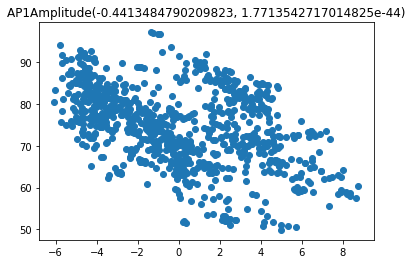

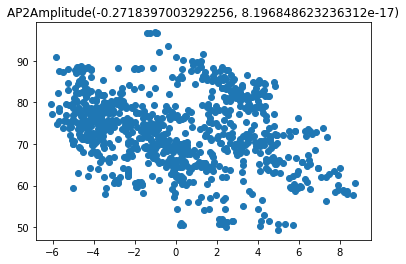

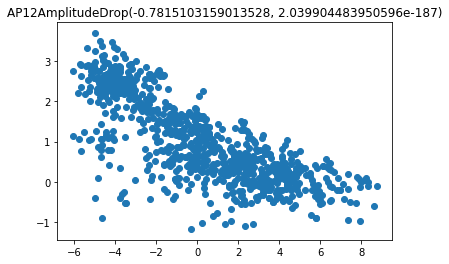

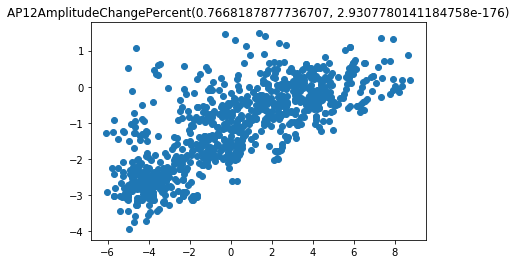

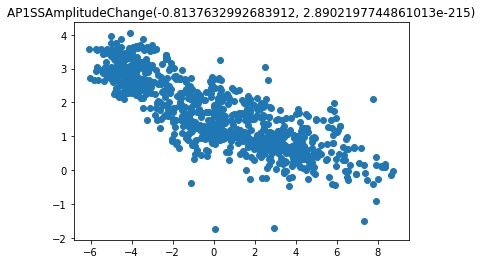

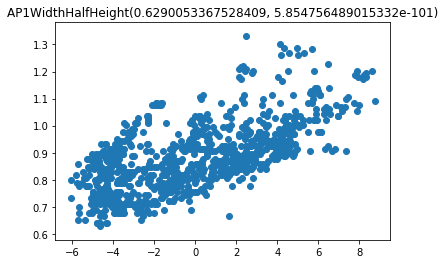

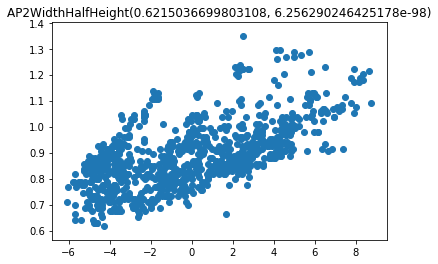

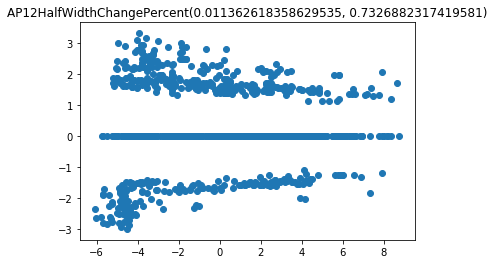

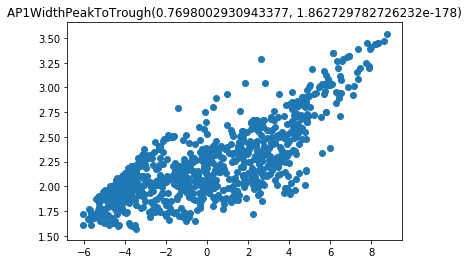

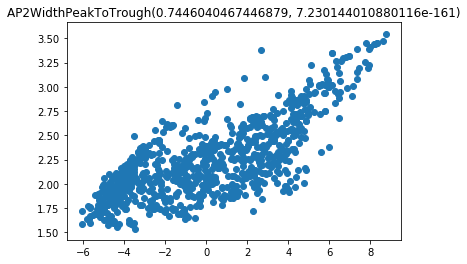

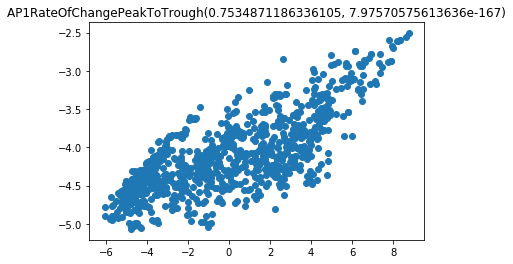

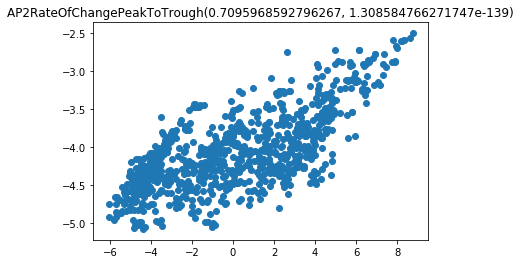

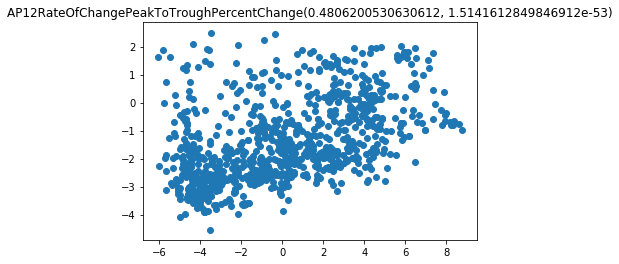

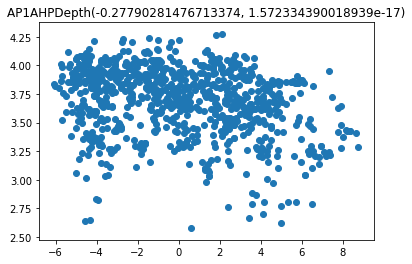

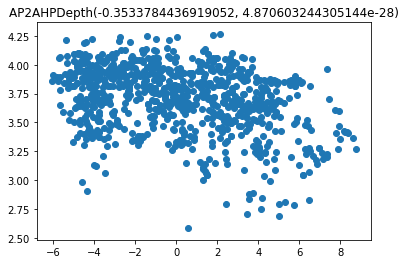

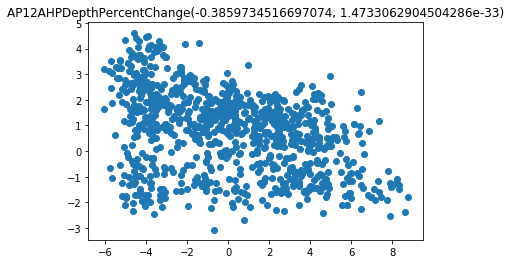

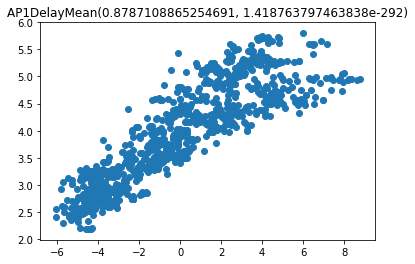

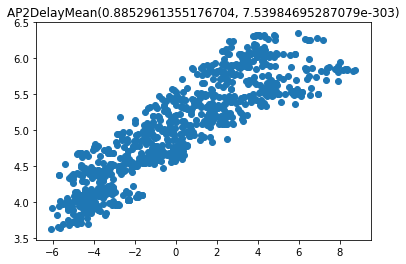

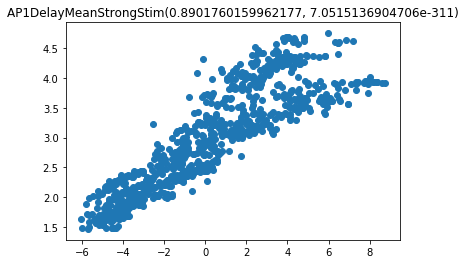

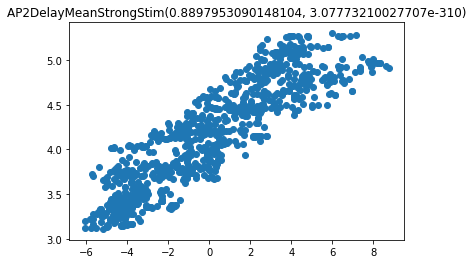

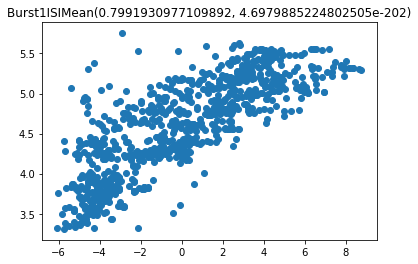

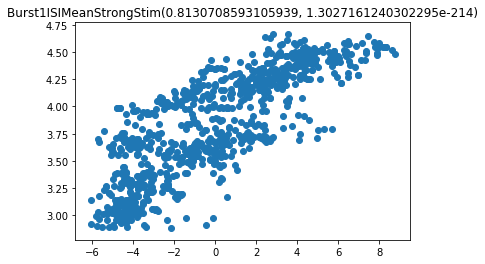

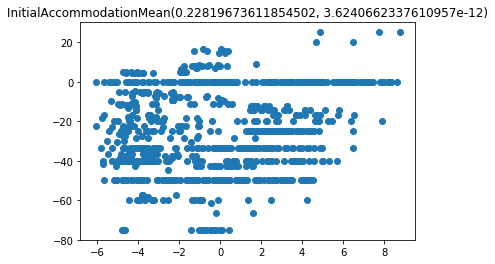

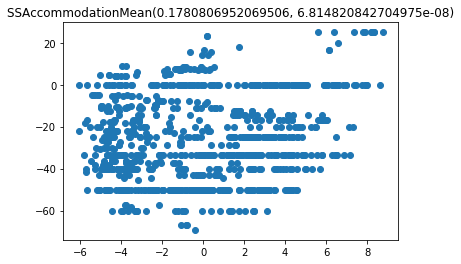

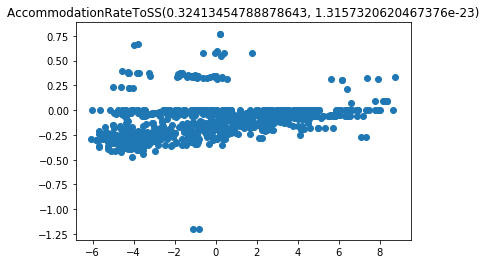

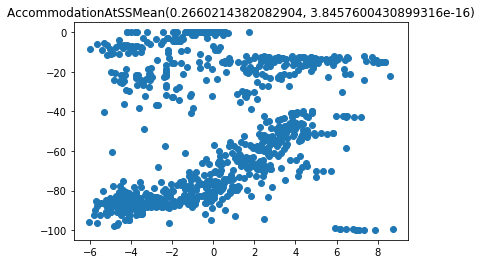

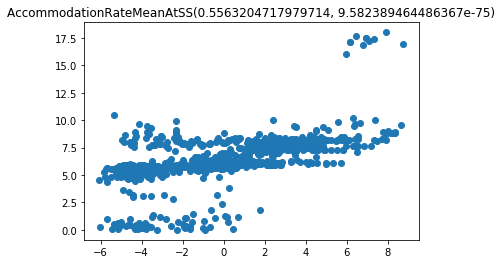

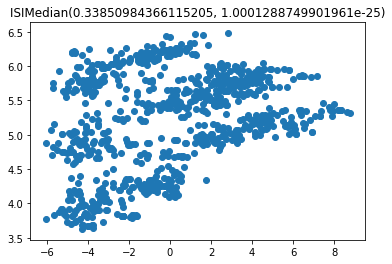

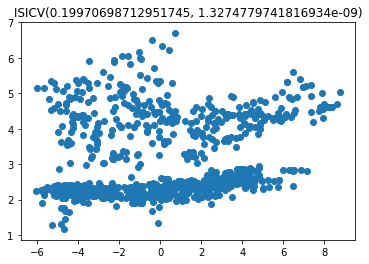

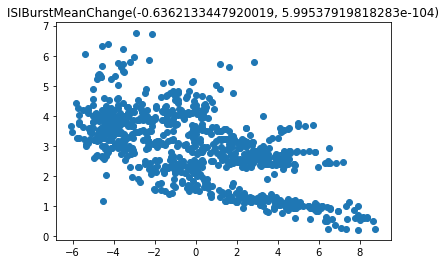

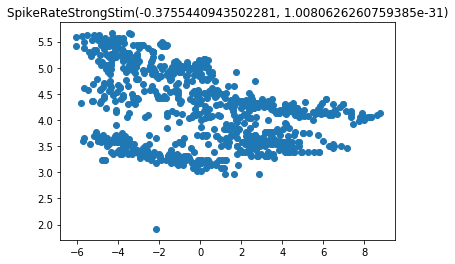

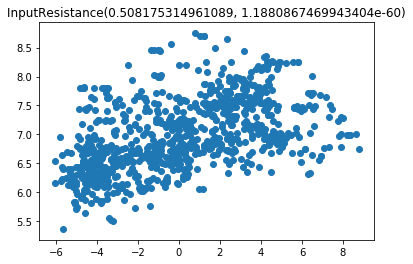

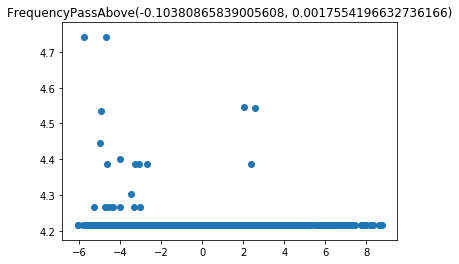

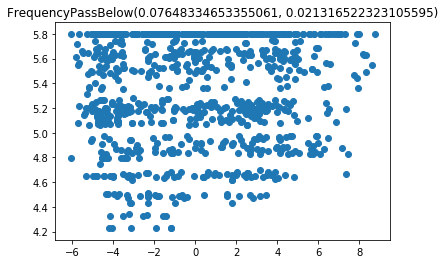

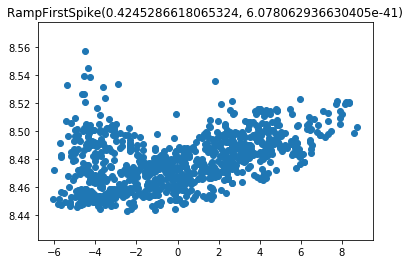

('failed', 'ClusterPath')


In [402]:
pc = 0
#col = "AP12AmplitudeDrop"
#if col == "AP12AmplitudeDrop":
for col in df.columns:
    try:
        if np.abs(pearsonr(X[pc],df[col])[0]) >= 0:
            plt.scatter(X[pc],df[col])
            plt.title((col + str(pearsonr(X[pc],df[col]))))
            plt.show();
#             plt.scatter(X[pc],df_non_trans[col])
#             plt.show();
    except:
        print('failed',col)

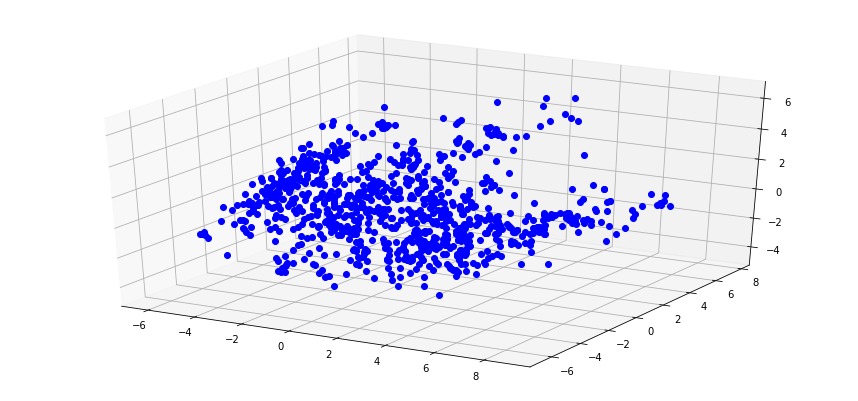

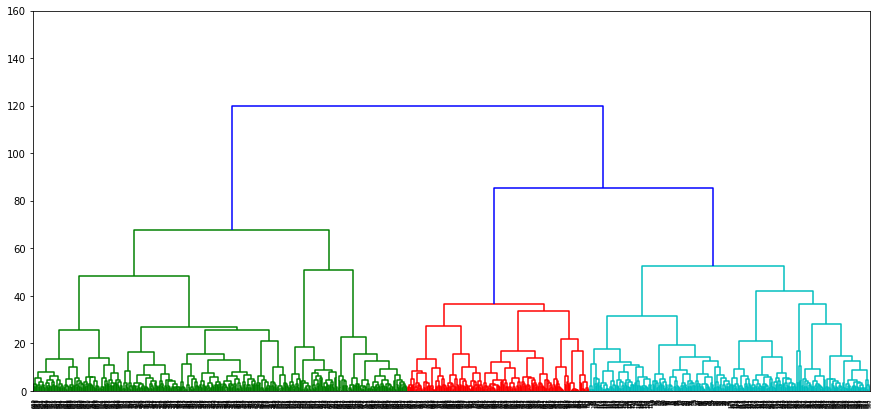

(906, 'items')
('For n_clusters =', 2, 'The average silhouette_score is :', 0.24065679343934723)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.23696451773489907)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.2213284651333041)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.23944198010918671)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.2504245051908243)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.25070643361497985)


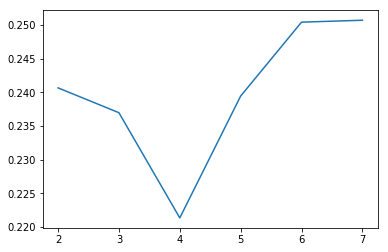

In [403]:
%matplotlib inline
from mpl_toolkits import mplot3d
plt.figure(figsize=(15, 7))  
plt.axes(projection='3d')
plt.plot(X[0],X[1], X[2],'bo')
plt.show()

from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt

linked = linkage(X, 'ward',optimal_ordering=False)

plt.figure(figsize=(15, 7))  
dendrogram(linked,  
            orientation='top',
            distance_sort='acending',
            show_leaf_counts=True,
            #truncate_mode='lastp',
            #p=5,
            show_contracted=True,
          )
plt.ylim(0,160)
plt.show()  

print(X.shape[0],'items')

from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = range(2, 8)

clusters = []
widths = []
for n_clusters in range_n_clusters:
    from sklearn.cluster import AgglomerativeClustering
    #clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')  
    clusterer = KMeans(n_clusters=n_clusters)  
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
    
    clusters.append(n_clusters)
    widths.append(silhouette_avg)

plt.plot(clusters, widths)
plt.show()

In [404]:
%matplotlib inline
i=0
comp_names = []
for i in range(3):
    
    prop_r = np.array([stats.pearsonr(X[i],df[col])[0] if stats.pearsonr(X[i],df[col])[1] < 0.001 else 0 for col in df.columns[:-2]])
    inds = (-np.abs(prop_r)).argsort()
#     plt.plot(range(len(pca.components_[0])), pca.components_[i][inds])
#     plt.show()
    print(np.array(prop_names)[inds][:5])
    print(prop_r[inds][:5])
    
    name = ""
    for f in range(3):
        name += ("-" if prop_r[inds][f] < 0 else "+") + prop_names[inds[f]]
    comp_names.append(name)
    print(name)
    print("         -----            ")
    


['AP1DelayMeanStrongStim' 'AP2DelayMeanStrongStim' 'AP2DelayMean'
 'AP1DelayMean' 'AP1SSAmplitudeChange']
[ 0.89017602  0.88979531  0.88529614  0.87871089 -0.8137633 ]
+AP1DelayMeanStrongStim+AP2DelayMeanStrongStim+AP2DelayMean
         -----            
['ISIMedian' 'SpikeRateStrongStim' 'SSAccommodationMean' 'ISICV'
 'InitialAccommodationMean']
[-0.79602242  0.77612978  0.73205653  0.69895767  0.686377  ]
-ISIMedian+SpikeRateStrongStim+SSAccommodationMean
         -----            
['AccommodationAtSSMean' 'ISICV' 'InitialAccommodationMean'
 'SSAccommodationMean' 'AP2Amplitude']
[-0.64980199 -0.56356389 -0.54585063 -0.5169553  -0.50113908]
-AccommodationAtSSMean-ISICV-InitialAccommodationMean
         -----            


In [405]:
comp_names

['+AP1DelayMeanStrongStim+AP2DelayMeanStrongStim+AP2DelayMean',
 '-ISIMedian+SpikeRateStrongStim+SSAccommodationMean',
 '-AccommodationAtSSMean-ISICV-InitialAccommodationMean']

In [436]:
%matplotlib inline

In [448]:
%matplotlib notebook
%matplotlib notebook

<IPython.core.display.Javascript object>


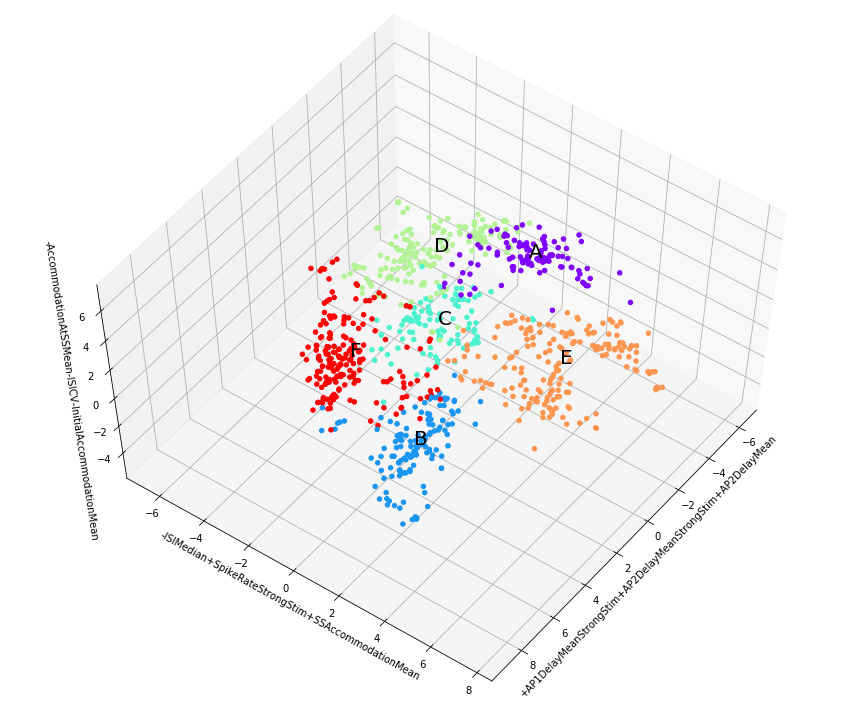

Counter({4: 192, 5: 190, 3: 182, 1: 133, 0: 106, 2: 103})
{'cells': Index([u'NMLCL000728', u'NMLCL000444', u'NMLCL000732', u'NMLCL000407',
       u'NMLCL000735'],
      dtype='object'),
 'center': ['       -3.91', '        0.58', '        1.56'],
 'cluster': 0,
 'sd': ['        1.10', '        1.53', '        1.32']}
{'cells': Index([u'NMLCL000829', u'NMLCL000870', u'NMLCL000794', u'NMLCL000881',
       u'NMLCL000908'],
      dtype='object'),
 'center': ['        4.80', '        1.73', '       -0.86'],
 'cluster': 1,
 'sd': ['        1.89', '        1.13', '        1.09']}
{'cells': Index([u'NMLCL000303', u'NMLCL000304', u'NMLCL000396', u'NMLCL000362',
       u'NMLCL000316'],
      dtype='object'),
 'center': ['        1.71', '        0.59', '        3.10'],
 'cluster': 2,
 'sd': ['        1.54', '        1.45', '        1.50']}
{'cells': Index([u'NMLCL000196', u'NMLCL000125', u'NMLCL000181', u'NMLCL000146',
       u'NMLCL000182'],
      dtype='object'),
 'center': ['       -2.45', '  

In [449]:
min_cluster_size=10
n_clusters=6
hide_noise = False
remove_noise = False
k_means = True

X_w_noise = X

if remove_noise:
    cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    cluster.fit_predict(X)
    X = X[cluster.labels_ != -1]
    
if k_means:
    cluster = KMeans(n_clusters=n_clusters,random_state=1)
    cluster.fit_predict(X)

else:
    cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    cluster.fit_predict(X)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

if hide_noise:
    ax.scatter(
        X[cluster.labels_ != -1][0],
        X[cluster.labels_ != -1][1], 
        X[cluster.labels_ != -1][2], depthshade=False,marker='o', 
        c=cluster.labels_[cluster.labels_ != -1], 
        cmap='rainbow')
    
else:
    ax.scatter(
        X[0],
        X[1], 
        X[2], depthshade=False,marker='o', 
        c=cluster.labels_, 
        cmap='rainbow')

ax.set_xlabel(comp_names[0])
ax.set_ylabel(comp_names[1])
ax.set_zlabel(comp_names[2])

# ax.set_xlabel("AP Onset")
# ax.set_ylabel("SS Spike Rate")
# ax.set_zlabel("SS Accommodation")
plt.tight_layout()

centers = []

if k_means:
    centers = cluster.cluster_centers_
else:
    labels = np.unique(cluster.labels_) if not hide_noise else np.unique(cluster.labels_[cluster.labels_ != -1])
    
    for l in labels:
        X_label = X[cluster.labels_ == l]
        center = [np.mean(X_label[c]) for c in range(X.shape[1])]
        centers.append(center)

for i, center in enumerate(centers):
    ax.text(center[0],center[1],center[2],string.ascii_uppercase[i],size=20)
    
plt.show()
#%matplotlib inline

import collections
print(collections.Counter(cluster.labels_))


for c, center in enumerate(centers):
    dist = np.apply_along_axis(euclidean, 1, X, center)
    dist_sort_is = dist.argsort()
    from pprint import pprint as pp

    pp({"cluster": c, 
        "cells": X.iloc[dist_sort_is].index[:5], 
        "sd":["{:12.2f}".format(np.std(X.iloc[np.where(cluster.labels_ == c)][pc])) for pc in range(3)],
        "center":["{:12.2f}".format(c) for c in center[0:3]],
       })

In [450]:
comp_names

['+AP1DelayMeanStrongStim+AP2DelayMeanStrongStim+AP2DelayMean',
 '-ISIMedian+SpikeRateStrongStim+SSAccommodationMean',
 '-AccommodationAtSSMean-ISICV-InitialAccommodationMean']

In [415]:
source_df.head()

,AP1Amplitude,AP2Amplitude,AP12AmplitudeDrop,AP12AmplitudeChangePercent,AP1SSAmplitudeChange,AP1WidthHalfHeight,AP2WidthHalfHeight,AP12HalfWidthChangePercent,AP1WidthPeakToTrough,AP2WidthPeakToTrough,AP1RateOfChangePeakToTrough,AP2RateOfChangePeakToTrough,AP12RateOfChangePeakToTroughPercentChange,AP1AHPDepth,AP2AHPDepth,AP12AHPDepthPercentChange,AP1DelayMean,AP2DelayMean,AP1DelaySD,AP2DelaySD,AP1DelayMeanStrongStim,AP2DelayMeanStrongStim,AP1DelaySDStrongStim,AP2DelaySDStrongStim,Burst1ISIMean,Burst1ISIMeanStrongStim,Burst1ISISD,Burst1ISISDStrongStim,InitialAccommodationMean,SSAccommodationMean,AccommodationRateToSS,AccommodationAtSSMean,AccommodationRateMeanAtSS,ISIMedian,ISICV,ISIBurstMeanChange,SpikeRateStrongStim,InputResistance,SteadyStateAPs,FrequencyPassAbove,FrequencyPassBelow,RampFirstSpike
NMLCL000092,75.318312,73.033827,2.284485,-3.033107,3.148155,0.50,0.51,2.000000e+00,4.69,4.96,-20.773250,-19.247443,-7.345057,22.108232,22.433492,1.471216,15.76,60.61,0.0,0.0,5.95,30.22,0.0,0.0,60.970,25.845,0.0,0.0,-50.0,-50.0,-0.129604,-86.429493,140.398213,215.385,2.905286,71.884058,10.0,364.014516,0,29.0,54.076556,2048.86
NMLCL000093,74.132193,74.034426,0.097767,-0.131882,0.749713,0.54,0.54,-2.055969e-14,3.52,3.56,-26.386294,-25.967982,-1.585337,18.747562,18.411591,-1.792076,26.61,87.20,0.0,0.0,8.53,37.66,0.0,0.0,71.825,30.930,0.0,0.0,-50.0,-50.0,-0.081778,-79.986536,193.720671,228.285,3.125901,37.085328,9.5,376.114183,0,29.0,143.000000,2080.10
NMLCL000094,76.411966,75.265300,1.146666,-1.500637,1.985168,0.45,0.44,-2.222222e+00,2.33,2.35,-42.034536,-41.239377,-1.891679,21.528502,21.647236,0.551520,20.14,71.19,0.0,0.0,5.64,30.79,0.0,0.0,56.685,26.430,0.0,0.0,-25.0,-50.0,-0.112727,-80.181722,193.788495,185.950,3.176031,22.076396,11.5,231.876608,0,29.0,38.519815,2055.15
NMLCL000096,76.065067,74.573458,1.491608,-1.960964,2.260686,0.50,0.50,0.000000e+00,3.00,3.05,-32.086379,-31.117447,-3.019761,20.194070,20.334755,0.696665,17.42,65.50,0.0,0.0,5.43,29.96,0.0,0.0,55.585,25.965,0.0,0.0,-50.0,-50.0,-0.095752,-83.697507,162.927412,204.080,3.070944,31.218802,10.5,344.103337,0,29.0,143.000000,2052.59
NMLCL000097,84.794944,83.369870,1.425074,-1.680612,2.112203,0.40,0.40,0.000000e+00,2.25,2.27,-47.361443,-46.353622,-2.127937,21.768304,21.852852,0.388400,14.39,57.38,0.0,0.0,4.65,28.16,0.0,0.0,48.605,24.740,0.0,0.0,-50.0,-25.0,-0.052543,-84.678760,141.729801,186.290,3.166407,26.122354,11.5,655.788905,0,29.0,79.810241,2045.69


In [434]:
%matplotlib %notebook

<IPython.core.display.Javascript object>


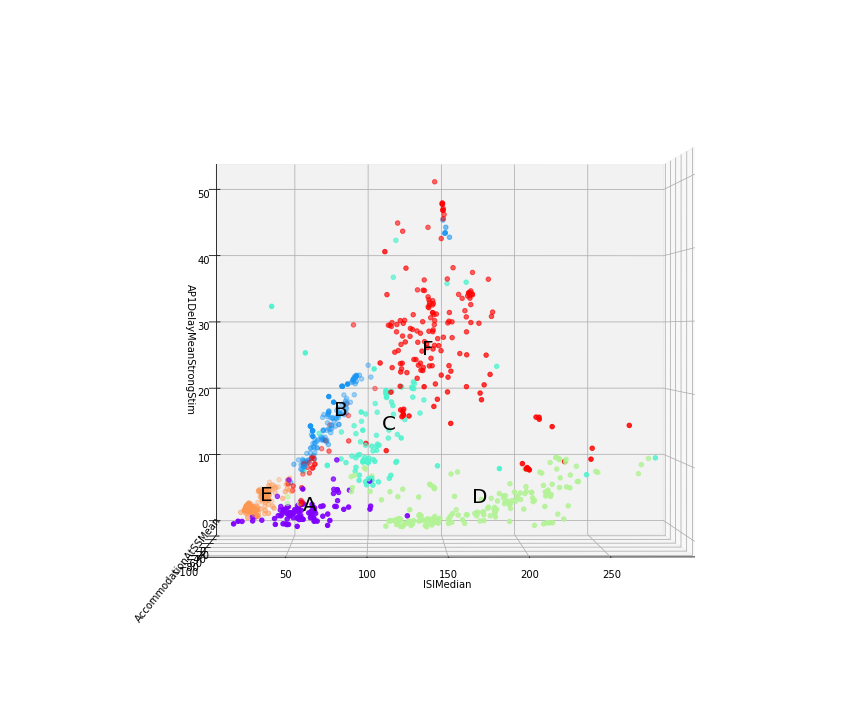

['ISIMedian', 'AccommodationAtSSMean', 'AP1DelayMeanStrongStim']
('A', ['59.35+/-17.45', '-85.02+/-7.80', '3.71+/-1.44'])
('reg params', array([9.50353176, 0.09893173, 0.04417263]))
('reg p vals', array([1.59011930e-13, 1.55481850e-11, 1.61907817e-11]))
('delay v accom', (0.46038057098427176, 6.854038797399689e-07))
('delay v isi', (0.4597177698736291, 7.144861969310133e-07))
('B', ['77.26+/-19.80', '-24.38+/-23.56', '16.17+/-7.14'])
('reg params', array([-11.50551661,  -0.03303291,   0.34773591]))
('reg p vals', array([3.79512740e-056, 9.78254719e-012, 5.23180381e-102]))
('delay v accom', (-0.2488323689623186, 0.003875052457218724))
('delay v isi', (0.9804801667652324, 2.0680352020768446e-94))
('C', ['109.14+/-30.28', '-70.23+/-8.43', '14.74+/-6.72'])
('reg params', array([24.52246718,  0.20490551,  0.04221639]))
('reg p vals', array([3.78537777e-05, 8.24799206e-03, 4.88378409e-02]))
('delay v accom', (0.2423943096258502, 0.013628149357596408))
('delay v isi', (0.1702656804925851, 0.0

In [462]:
source_df = df_no_trans.ix[X.index]

display_props = ["ISIMedian","AccommodationAtSSMean","AP1DelayMeanStrongStim"]
#display_props = ["AP1DelayMeanStrongStim","ISIMedian","AccommodationAtSSMean"]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    source_df[display_props[0]],
    source_df[display_props[1]], 
    source_df[display_props[2]], 
    depthshade=True,
    marker='o', 
    c=cluster.labels_, 
    cmap='rainbow')

ax.set_xlabel(display_props[0])
ax.set_ylabel(display_props[1])
ax.set_zlabel(display_props[2])

plt.tight_layout()

centers = []
sds = []

labels = np.unique(cluster.labels_)

print(display_props)

for i, l in enumerate(labels):
    X_label = source_df[cluster.labels_ == l]
    center = [np.mean(X_label[prop]) for prop in display_props]
    centers.append(center)
    
    sd = [np.std(X_label[prop]) for prop in display_props]
    sds.append(sd)
    
    ax.text(center[0],center[1],center[2],string.ascii_uppercase[i],size=20)
    
    print(string.ascii_uppercase[i],["{:0.2f}+/-{:0.2f}".format(centers[i][c],sds[i][c]) for c,_ in enumerate(center)])
    
    reg = smf.ols('AP1DelayMeanStrongStim~AccommodationAtSSMean+ISIMedian',data=X_label).fit()
    print('reg params',reg._results.params)
    print('reg p vals',reg._results.pvalues)
    print("delay v accom",stats.pearsonr(X_label["AP1DelayMeanStrongStim"],X_label["AccommodationAtSSMean"]))
    print("delay v isi",stats.pearsonr(X_label["AP1DelayMeanStrongStim"],X_label["ISIMedian"]))
    
    
plt.show()        

#%matplotlib inline


In [459]:
dir(smf.ols('AP1DelayMeanStrongStim~AccommodationAtSSMean+ISIMedian',data=X_label).fit()._results)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_data_attr',
 '_get_robustcov_results',
 '_is_nested',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robustcov_results',
 'initialize',
 'k_constant',
 'llf',
 'load',
 'model',
 'mse_model',
 'mse_resid',
 'mse_total',
 'nobs',
 'normalized_cov_params',
 'outlier_test',
 'params',
 'pre

In [392]:
comp_names

['-AP2DelayMean-AP1DelayMean-AP2DelayMeanStrongStim',
 '+SSAccommodationMean+InitialAccommodationMean+ISICV',
 '-AP2RateOfChangePeakToTrough+AP1AHPDepth-AP2WidthPeakToTrough']

In [393]:
X_w_labels = DataFrame(X)

In [394]:
X["Cluster"] = cluster.labels_

In [395]:
#X_w_noise.loc[X.index]['Cluster']#=cluster.labels_

for label in X.index:
    X_w_noise.at[label, "Cluster"] = X.at[label, "Cluster"]
    

In [396]:
np.unique(X_w_noise["Cluster"])

array([-1.,  0.,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

           delay       short aps/ISIs       accom    


2 ['        1.37', '        1.29', '        2.55'] large accomodotation, mild delay, short aps
regular spikers

4 ['        2.97', '        1.24', '       -1.17'] delayed, regular spiking, mild accomodating
non-accomodating regular spikers



0 ['        3.43', '       -2.73', '       -0.49'] delayed, tall APs, long isis
slow spikers

3 ['       -1.98', '       -2.06', '        0.96'] non delayed, long isis, accommodating
rapid onset slow spikers


5 ['       -3.69', '        0.71', '        1.40'] rapid onset+accomodation (=burst?), reg? spiking
bursters


1 ['       -1.90', '        2.06', '       -2.26'] non delayed, non-accomodating, short aps, short isis
rapid onset, non-accomodoating, fast spikers



within clusters:

correlation between 
	accom and short ap/isis
	short ap/isis and ap delay


In [397]:
df["Cluster"] = X_w_noise["Cluster"]

df["ClusterPath"] = parent_path + df["Cluster"].map(str) + "/"

for label in df.index:
    df_all.at[label, "ClusterPath"] = df.at[label, "ClusterPath"]
    df_all.at[label, "Cluster"] = df.at[label, "Cluster"]

np.unique(df["ClusterPath"])

array(['/3/-1.0/', '/3/0.0/', '/3/1.0/', '/3/nan/'], dtype=object)

In [398]:
np.unique(df_all["ClusterPath"])

array(['/-1/', '/0/', '/1/', '/2/', '/3/-1.0/', '/3/0.0/', '/3/1.0/',
       '/3/nan/'], dtype=object)

# End clustering

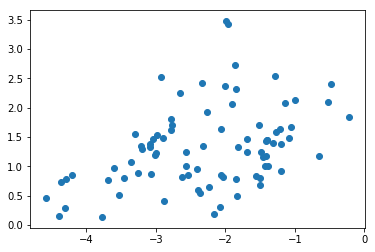

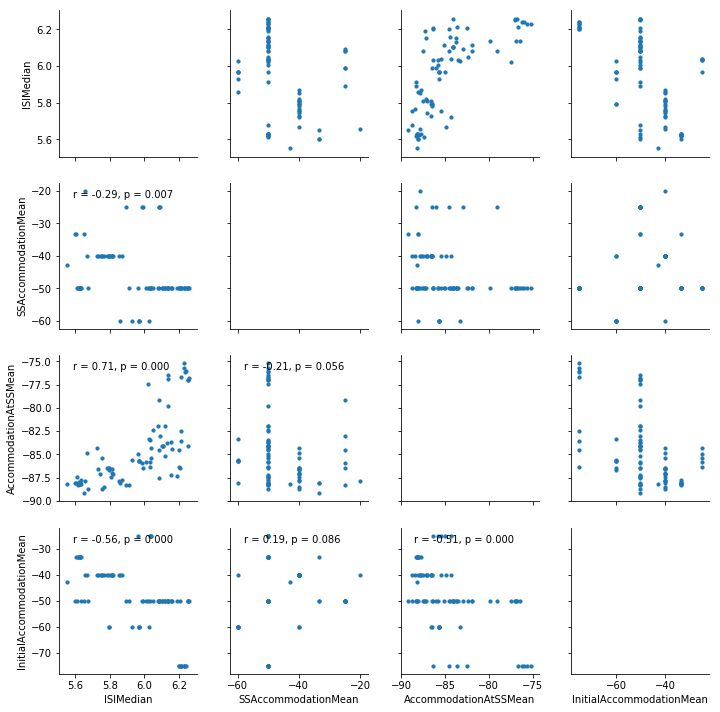

In [175]:
cl = 0
cluster_rows = X[cluster.labels_ == cl]
plt.scatter(cluster_rows[1],cluster_rows[2])
plt.show()
from scipy import stats
def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}, p = {:.3f}".format(r,p),
                xy=(.1, .9), xycoords=ax.transAxes)
    
import seaborn as sns
g = sns.PairGrid(df_all.ix[cluster_rows.index],vars=["ISIMedian","SSAccommodationMean","AccommodationAtSSMean","InitialAccommodationMean"])
g.map_upper(plt.scatter, s=10)
g.map_lower(plt.scatter, s=10)
g.map_lower(corrfunc)

In [157]:
cluster_rows[cluster_rows[1].min() == cluster_rows[1]]

,0,1,2,3,4,5,6,7,8,9,10,11,12
NMLCL000783,1.527462,-1.034446,-2.601998,1.700637,-0.090731,-1.236097,0.028645,0.4805,-0.794068,-0.877757,0.034354,0.362322,0.042066


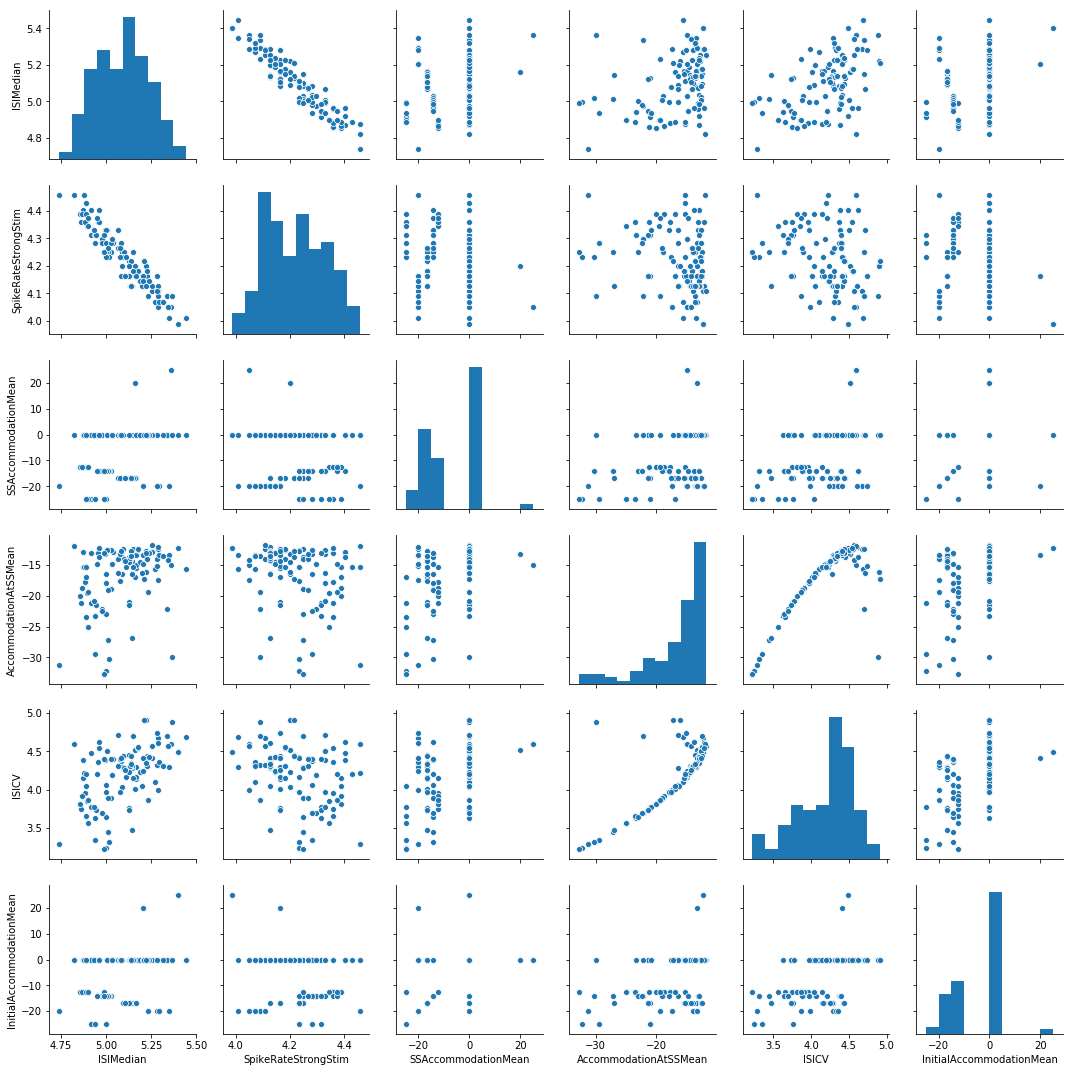

In [316]:
cell_records = list(Cells\
    .select(Cells,Model_Waveforms.Spikes,Models.Name)\
    .join(Model_Waveforms, on=(Cells.Model_ID == Model_Waveforms.Model_id))\
    .join(Models, on=(Cells.Model_ID == Models.Model_ID))\
    .where((Model_Waveforms.Protocol == "STEADY_STATE") & (Model_Waveforms.Variable_Name == "Voltage"))\
    .order_by(Cells.Model_ID)
)

In [161]:
df_all.loc["NMLCL001124"]["ClusterPath"]

'/1/-1/'

In [167]:
for cell_id in df_all.index:
    cell = next(cell for cell in cell_records if cell.Model_ID == cell_id)
    cell.ClusterPath = df_all.loc[cell_id]["ClusterPath"]

In [168]:
np.unique([cell.ClusterPath for cell in cell_records])

array(['/0/', '/1/-1/', '/1/0/', '/1/1/-1/', '/1/1/0/', '/1/1/1/',
       '/1/1/2/', '/1/1/3/', '/1/1/4/', '/1/1/5/'], dtype='|S8')

In [110]:
X_w_noise

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,Cluster
NMLCL000092,-0.388150,-2.903057,-0.414549,0.804703,0.048261,0.834370,-1.751868,-0.399088,0.368860,0.185240,0.239487,0.689365,-0.340879,0.622459,0.003893,-0.572928,0.098728,-0.334199,-0.005877,0.082611,0.232950,1
NMLCL000093,1.149632,-1.820371,-1.965433,-0.231131,0.944057,0.011757,-0.529292,-0.306498,1.076724,-0.521271,0.073504,0.028040,0.377765,-0.151386,0.228591,0.508310,0.916718,0.087066,0.205714,0.366195,-0.049026,1
NMLCL000094,-0.888507,-1.683425,-2.417068,0.519445,-0.513980,0.220856,-0.576164,0.082851,0.065680,0.289318,-0.613394,0.591259,-0.490183,1.060413,-0.395612,-1.505597,0.491815,0.210525,0.357041,-0.019870,-0.677017,1
NMLCL000096,-0.537315,-2.385830,-1.318610,0.191149,0.370131,0.392962,-0.272259,-0.099228,1.025878,-0.009367,-0.159219,-0.268891,-0.049641,-0.257100,0.562693,0.065005,0.826000,0.259956,0.328201,-0.045846,0.490920,1
NMLCL000097,-1.444155,-1.982917,-2.618932,0.610992,-0.624852,0.258955,-0.493851,-0.250734,0.654148,0.474065,0.277271,0.063728,0.103285,-0.221197,-0.002748,-0.183577,0.316499,0.042695,0.515770,0.287894,0.248072,1
NMLCL000098,-1.287983,-2.302819,-2.868192,0.363660,-0.152982,0.265114,-0.019053,-0.202261,1.089494,-0.100393,-0.098479,-0.355997,0.078439,-0.499130,0.411521,0.303121,0.645431,0.232427,0.371169,0.292148,0.813403,1
NMLCL000101,1.765875,-2.734104,-0.666300,0.109030,-0.519825,0.651497,-1.564688,-0.673328,0.810866,0.181690,-0.311183,0.206448,-0.296343,0.622250,0.093539,-0.260871,0.129485,-0.336921,-0.000152,0.435660,0.199830,1
NMLCL000103,0.148100,-3.662661,-1.119939,0.621160,0.259370,0.488702,-0.905724,0.289252,-0.375120,-0.646234,-0.685726,0.271084,-0.433740,1.215642,-0.059398,-0.615408,0.362122,1.330641,-1.059890,0.204094,-1.064843,1
NMLCL000104,-2.479994,-2.829925,0.145922,2.059115,0.591465,1.308099,-1.321622,0.824845,1.476894,-0.133128,0.533525,-1.168089,-0.145910,-1.021450,0.635644,-0.390594,0.180969,-0.642157,0.228434,0.156448,0.116624,1
NMLCL000105,0.259386,-2.572381,0.300922,0.404745,1.482355,0.396040,-1.406767,-0.478476,0.716164,-0.257820,0.829750,0.172744,0.345431,-0.434126,0.459916,0.545130,0.819202,0.300249,0.065202,-0.002632,0.082360,1


In [ ]:
isimedian ~ delays + accomodations

ISIMedian  
AP1Amplitude
AP2Amplitude

AP1DelayMean
AP2DelayMean

InitialAccommodationMean
SSAccommodationMean
AccommodationAtSSMean

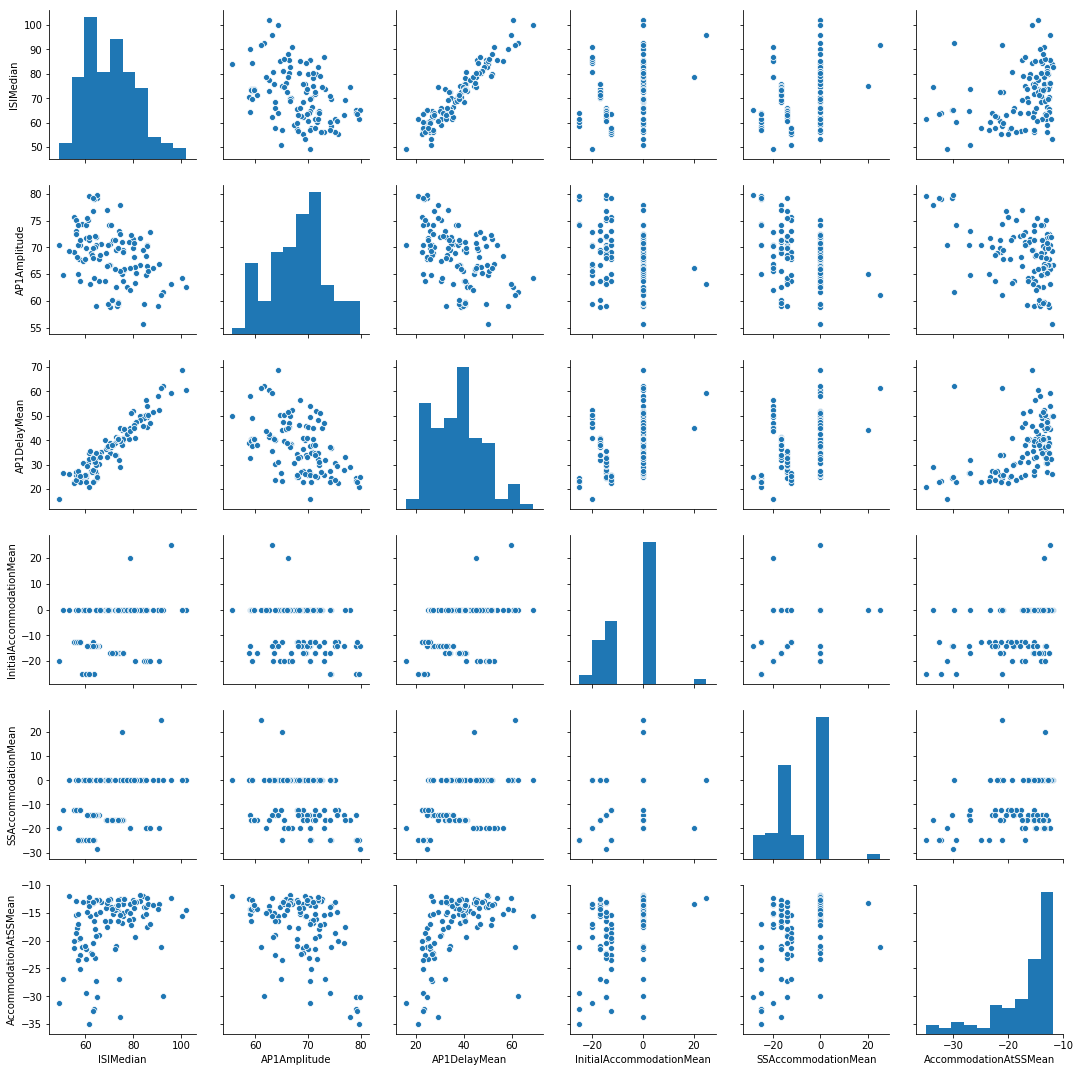

In [126]:
sns.pairplot(cl4_raw,vars=[
    "ISIMedian",
"AP1Amplitude",
"AP1DelayMean",
"InitialAccommodationMean",
"SSAccommodationMean",
"AccommodationAtSSMean"])

In [132]:
smf.ols('AP1DelayMean~InitialAccommodationMean+SSAccommodationMean+AccommodationAtSSMean+ISIMedian',data=cl4_raw).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AP1DelayMean   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     499.1
Date:                Sun, 06 Jan 2019   Prob (F-statistic):           1.18e-71
Time:                        15:34:39   Log-Likelihood:                -277.60
No. Observations:                 120   AIC:                             565.2
Df Residuals:                     115   BIC:                             579.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  -14.5451      2.004     -7.259      0.000     -18.514     -10.576
InitialAccommodationMean     0.0803      0.030      2.718      0.008       0.022       0.139
SSAccommodationMean          0.0623      0.027      2.282      0.024       0.008       0.116
AccommodationAtSSMean        0.3271      0.049      6.676      0.000       0.230       0.424
ISIMedian                    0.8241      0.023     36.058      0.000       0.779       0.869
==============================================================================
Omnibus:                       45.414   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.486
Skew:                           1.476   Prob(JB):                     2.27e-25
Kurtosis:                       6.740   Cond. No.                         656.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [177]:
plt.hist(cl4_raw[col])
plt.show()

('Cluster', 0)


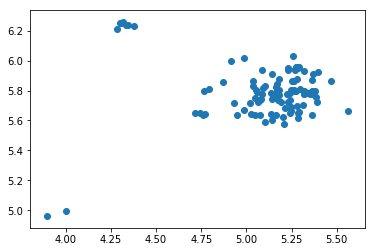

('AP1DelayMean', 'ISIMedian', (-0.05444268018008502, 0.5812204966447025))
                            OLS Regression Results                            
Dep. Variable:           AP1DelayMean   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.3062
Date:                Wed, 09 Jan 2019   Prob (F-statistic):              0.581
Time:                        11:28:46   Log-Likelihood:                -26.028
No. Observations:                 105   AIC:                             56.06
Df Residuals:                     103   BIC:                             61.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

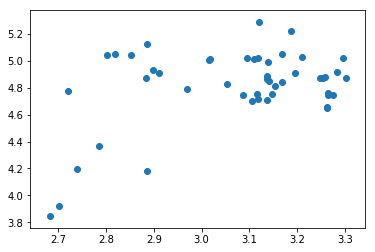

('AP1DelayMean', 'ISIMedian', (0.43199043750518046, 0.0021693304139102075))
                            OLS Regression Results                            
Dep. Variable:           AP1DelayMean   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     10.55
Date:                Wed, 09 Jan 2019   Prob (F-statistic):            0.00217
Time:                        11:28:46   Log-Likelihood:                 19.719
No. Observations:                  48   AIC:                            -35.44
Df Residuals:                      46   BIC:                            -31.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

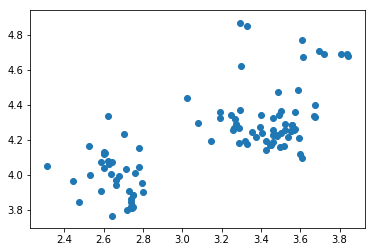

('AP1DelayMean', 'ISIMedian', (0.714871308096648, 1.5535798673374773e-17))
                            OLS Regression Results                            
Dep. Variable:           AP1DelayMean   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     106.6
Date:                Wed, 09 Jan 2019   Prob (F-statistic):           1.55e-17
Time:                        11:28:47   Log-Likelihood:                -18.827
No. Observations:                 104   AIC:                             41.65
Df Residuals:                     102   BIC:                             46.94
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

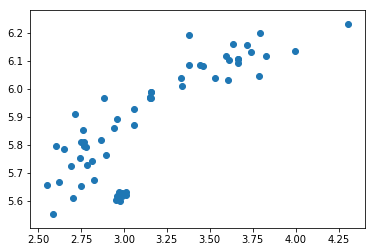

('AP1DelayMean', 'ISIMedian', (0.8292950419274249, 1.5185179931322676e-16))
                            OLS Regression Results                            
Dep. Variable:           AP1DelayMean   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     129.9
Date:                Wed, 09 Jan 2019   Prob (F-statistic):           1.52e-16
Time:                        11:28:47   Log-Likelihood:                 3.3789
No. Observations:                  61   AIC:                            -2.758
Df Residuals:                      59   BIC:                             1.464
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

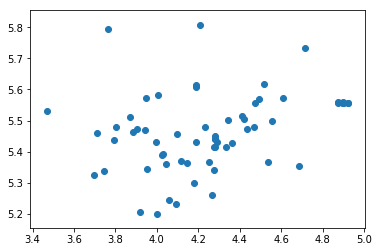

('AP1DelayMean', 'ISIMedian', (0.31119116935906027, 0.013045716699345145))
                            OLS Regression Results                            
Dep. Variable:           AP1DelayMean   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     6.541
Date:                Wed, 09 Jan 2019   Prob (F-statistic):             0.0130
Time:                        11:28:47   Log-Likelihood:                -20.158
No. Observations:                  63   AIC:                             44.32
Df Residuals:                      61   BIC:                             48.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

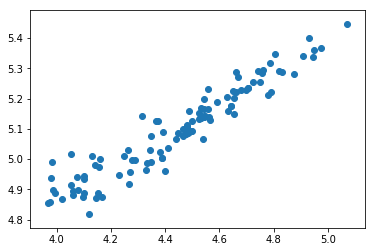

('AP1DelayMean', 'ISIMedian', (0.9501358952899367, 5.729937310680522e-56))
                            OLS Regression Results                            
Dep. Variable:           AP1DelayMean   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     993.4
Date:                Wed, 09 Jan 2019   Prob (F-statistic):           5.73e-56
Time:                        11:28:47   Log-Likelihood:                 116.53
No. Observations:                 109   AIC:                            -229.1
Df Residuals:                     107   BIC:                            -223.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

In [178]:
%matplotlib inline
cols = ["ISIMedian"]

for cl in range(6):
    print("Cluster", cl)
    cl4 = np.where(cluster.labels_ == cl)
    cl4_data = X.iloc[cl4]
    
    cl4_data.columns = ["PC" + str(c) for c in cl4_data.columns]
    cl4_raw = df_all.loc[cl4_data.index]
    
    
    for col in cols:
        plt.scatter(cl4_raw["AP1DelayMean"], cl4_raw[col]); plt.show();
        print("AP1DelayMean",col,pearsonr(cl4_raw["AP1DelayMean"], cl4_raw[col]))
        print(smf.ols('AP1DelayMean~'+col,data=cl4_raw).fit().summary())
    print("---")

In [391]:
fr._results.params[1]

0.3880398324824767

In [243]:
import collections
collections.Counter(df_all["ClusterPath"])

Counter({'/-1/': 27,
         '/0/': 12,
         '/1/': 39,
         '/2/-1/': 157,
         '/2/0/': 32,
         '/2/1/-1/-1/-1/': 446,
         '/2/1/0/0/0/': 35,
         '/2/1/1/1/1/': 86,
         '/2/1/2/2/2/': 203,
         '/2/1/3/3/3/': 95,
         '/2/1/4/4/4/': 17,
         '/2/1/5/5/5/': 73})

In [336]:
X_w_noise_clusters = []
X_w_noise_cluster_dists = []
for row_id in X_w_noise.index:
    cl_dists = []
    for cl, center in enumerate(cluster.cluster_centers_):
        cl_dists.append(euclidean(X_w_noise.loc[row_id], center))
    dist_sorted = np.argsort(cl_dists)
    X_w_noise_clusters.append(dist_sorted[0:3])
    X_w_noise_cluster_dists.append(np.array(cl_dists)[dist_sorted[0:3]])
X_w_noise_clusters = np.array(X_w_noise_clusters)
X_w_noise_clusters

array([[4, 1, 3],
       [3, 0, 4],
       [3, 0, 4],
       ...,
       [4, 3, 1],
       [4, 2, 3],
       [4, 2, 3]])

In [350]:
X_w_noise_clusters

array([[4, 1, 3],
       [3, 0, 4],
       [3, 0, 4],
       ...,
       [4, 3, 1],
       [4, 2, 3],
       [4, 2, 3]])

In [355]:
record.Cell_ID

u'NMLCL001642'

In [ ]:
for i, cell_id in enumerate(X_w_noise.index):
    print(cell_id)
    for cli, cl in enumerate(X_w_noise_clusters[i]):
        record = Cell_Closest_Ephyz_Clusters()
        record.Cell_ID = cell_id
        record.Cluster_ID = parent_path + str(cl) + "/"
        record.Distance = X_w_noise_cluster_dists[i][cli]
        record.save()

In [368]:
from database import NMLDB

In [370]:
db = NMLDB()
db.connect()

Connecting to server...
Connecting to MySQL database...


In [414]:
%matplotlib notebook
%matplotlib notebook

<IPython.core.display.Javascript object>


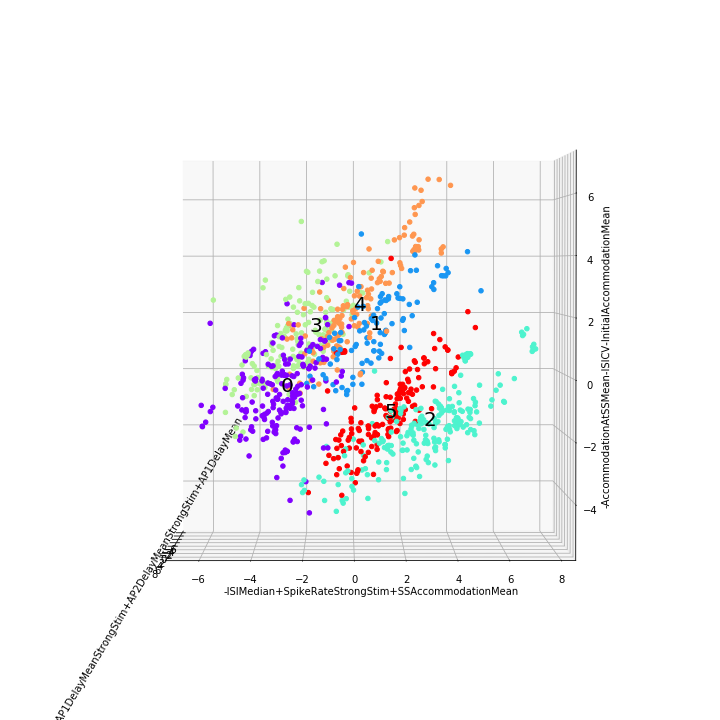

In [415]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
        X_w_noise[0],
        X_w_noise[1], 
        X_w_noise[2], depthshade=False,marker='o', 
        c=X_w_noise_clusters[:,0], 
        cmap='rainbow')

ax.set_xlabel(comp_names[0])
ax.set_ylabel(comp_names[1])
ax.set_zlabel(comp_names[2])

plt.tight_layout()

for i, center in enumerate(cluster.cluster_centers_):
    ax.text(center[0],center[1],center[2],str(i),size=20)

plt.show()

In [420]:
#%matplotlib inline
from scipy.stats import pearsonr
cols = [
"PC0",
#"PC0"
]

for cl in range(6):
    print("Cluster", cl)
    cl_ids = np.where(X_w_noise_clusters[:,0] == cl)
    cl_data = X_w_noise.iloc[cl_ids]
    
    cl_data.columns = ["PC" + str(c) for c in cl_data.columns]
    cl_raw = df_all.loc[cl_data.index]
    
    
    for col in cols:
        corr = pearsonr(cl_data["PC1"], cl_data[col])
        
        #plt.scatter(cl_data["PC1"], cl_data[col]);plt.show();
        fr = smf.ols('PC1~'+col,data=cl_data).fit()
        print("PC1",col,corr[0],corr[1] < 0.05)
        print('coeff',fr._results.params[1])
        #print(fr.summary())
    print("---")

('Cluster', 0)
('PC1', 'PC0', 0.6680380604221101, True)
('coeff', 0.48188318834555194)
---
('Cluster', 1)
('PC1', 'PC0', 0.4257880110902361, True)
('coeff', 0.6824041029280263)
---
('Cluster', 2)
('PC1', 'PC0', 0.1366866526839208, False)
('coeff', 0.1599325632040372)
---
('Cluster', 3)
('PC1', 'PC0', -0.021873382403861788, False)
('coeff', -0.020777302775312416)
---
('Cluster', 4)
('PC1', 'PC0', 0.6279560095869082, True)
('coeff', 0.5543514799711715)
---
('Cluster', 5)
('PC1', 'PC0', 0.6035711861017631, True)
('coeff', 0.3880398324824767)
---


In [436]:

from scipy.stats import pearsonr
y = "AP1DelayMeanStrongStim"
cols = [
"ISIMedian",
#"PC0"
]

for cl in range(6):
    print("Cluster", cl)
    cl_ids = np.where(X_w_noise_clusters[:,0] == cl)
    cl_data = X_w_noise.iloc[cl_ids]
    
    cl_data.columns = ["PC" + str(c) for c in cl_data.columns]
    cl_raw = df_all.loc[cl_data.index]
    
    
    for col in cols:
        corr = pearsonr(cl_raw[y], cl_raw[col])
        
        #%matplotlib inline
        #plt.scatter(cl_raw[y], cl_raw[col]);plt.show();
        fr = smf.ols(y+'~'+col,data=cl_raw).fit()
        print(y,col,corr[0],corr[1] < 0.05)
        print('coeff',fr._results.params[1])
        #print(fr.summary())
    print("---")

('Cluster', 0)
('AP1DelayMeanStrongStim', 'ISIMedian', -0.18220927324591513, True)
('coeff', -0.344335181916572)
---
('Cluster', 1)
('AP1DelayMeanStrongStim', 'ISIMedian', 0.4062889365915607, True)
('coeff', 0.33184091550025)
---
('Cluster', 2)
('AP1DelayMeanStrongStim', 'ISIMedian', 0.7394473837357323, True)
('coeff', 0.8696829000604159)
---
('Cluster', 3)
('AP1DelayMeanStrongStim', 'ISIMedian', 0.5831480744321108, True)
('coeff', 1.0463211117431304)
---
('Cluster', 4)
('AP1DelayMeanStrongStim', 'ISIMedian', -0.012250291712060737, False)
('coeff', -0.018524949299413895)
---
('Cluster', 5)
('AP1DelayMeanStrongStim', 'ISIMedian', 0.9546057951310148, True)
('coeff', 1.604855212209282)
---


2019-01-12 11:06:32,760| ERROR   | Socket exception: Connection reset by peer (104)
2019-01-12 11:06:50,674| ERROR   | Socket exception: Connection reset by peer (104)
2019-01-12 11:06:50,683| ERROR   | Socket exception: Connection reset by peer (104)
2019-01-12 13:12:46,387| ERROR   | Socket exception: Connection reset by peer (104)
2019-01-19 10:46:13,733| ERROR   | Socket exception: Connection reset by peer (104)
2019-01-19 10:46:14,945| ERROR   | Socket exception: Connection reset by peer (104)
2019-01-19 10:46:15,713| ERROR   | Socket exception: Connection reset by peer (104)
